# Understanding YOLO Output

## Yolo output have 3 scale and each scale have 3 anchor
(x,y, (anchor*5+class) )
(x,y,anchor,5+class) 5 - > consist of (x,y,w,h,conf)

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda ,Reshape
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from model.core import yolo_head,preprocess_true_boxes, yolo_loss
from model.mobilenet import yolo_body
from model.yolo3 import tiny_yolo_body
from model.utils import get_random_data

from tqdm import tqdm
import time

In [7]:

def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

In [8]:
def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes,model):
    '''data generator for fit_generator'''

    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=False)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
       # print(image_data.shape)
        m_true = model.predict(image_data)
     

        yield image_data , box_data , y_true , m_true  #, np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes,model):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes,model)

In [9]:
train_path = '2007_train.txt'
val_path = '2007_val.txt'
# test_path = '2007_test.txt'
log_dir = 'logs/000/'
classes_path = 'class/voc_classes.txt'
anchors_path = 'anchors/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)
num_anchors = len(anchors)

input_shape = (416,416) # multiple of 32, hw

with open(train_path) as f:
    train_lines = f.readlines()

with open(val_path) as f:
    val_lines = f.readlines()

# with open(test_path) as f:
#     test_lines = f.readlines()

num_anchors = len(anchors)
image_input = Input(shape=(416, 416, 3))
model = yolo_body(image_input, num_anchors//3, num_classes)
model.load_weights("model_data/trained_distillation_weights_final_mobilenet_v2.h5")

yolo3 = Reshape((13, 13, 3, 25))(model.layers[-3].output)
yolo2 = Reshape((26, 26, 3, 25))(model.layers[-2].output)
yolo1 = Reshape((52, 52, 3, 25))(model.layers[-1].output)


model = Model( inputs= model.input , outputs=[yolo3,yolo2,yolo1] )

batch_size = 1

In [10]:

        # create an hdf5 file
train_size = 5 #len(train_lines)
image = {}
box = {}
train_logits = {}
model_logits = {}

print( "total "+ str(len(train_lines)) + " loop "+ str( train_size ) )

i = 0 #step
for  img,box_data,flogits,mlogits in data_generator_wrapper(train_lines, batch_size, input_shape, anchors, num_classes,model) : 
    #x , y = dat
    image[i] = img
    box[i] = box_data
    train_logits[i] = flogits
    model_logits[i] = mlogits

    i+=1
    if i>= train_size:#(len(train_lines)) :
        break

total 2501 loop 5


In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [12]:
ch = 2
obj = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

In [13]:
box[ch]

array([[[  0.,  70., 287., 346.,   6.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.]]])

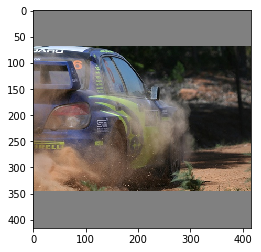

In [14]:
plt.imshow(image[ch][0])
plt.show()

In [15]:
train_logits[ch][0].shape

(1, 13, 13, 3, 25)

In [16]:
train_logits[ch][1].shape

(1, 26, 26, 3, 25)

In [17]:
train_logits[ch][2].shape

(1, 52, 52, 3, 25)

In [18]:
np.set_printoptions(threshold=np.inf)

### Real Dataset

Large Object (1,13,13,3,25) , Medium Object (1,26,26,3,25),Small Object (1,52,52,3,25)

In [19]:
lrg = train_logits[ch][0]
med = train_logits[ch][1]
sml = train_logits[ch][2]

In [20]:
lrgm = model_logits[ch][0]
medm = model_logits[ch][1]
smlm = model_logits[ch][2]

Change the Variable to see other scale

In [21]:
arrpl = lrg
arrpl[:,:,:,:,:] #xy wh p classes/20/ (1, 13, 13, 3, 25)
boxl = np.where(arrpl[:,:,:,:,4] > 0 )
boxl

(array([0], dtype=int64),
 array([6], dtype=int64),
 array([4], dtype=int64),
 array([2], dtype=int64))

x,y,w,h,p and class

In [22]:
box = boxl
arrp= arrpl
for i in range(len(box[0])):
    s = np.array(box)
    #print( i*5 )
    stp = i
   
    print( "({},{},{},{})".format(s[0,stp],s[1,stp],s[2,stp],s[3,stp]) )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],0:5] )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25] )
    obnum =  np.argmax( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25]) 
    print( "{} = {}".format(obnum, obj[ obnum ] ) )
    print("-------------------------------------------------------")

(0,6,4,2)
[0.34375    0.5        0.68990386 0.66346157 1.        ]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
6 = car
-------------------------------------------------------


In [23]:
arrpm = med
boxm = np.where(arrpm[:,:,:,:,4] > 0 )
boxm

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

In [24]:
box = boxm
arrp= arrpm
for i in range(len(box[0]) ):
    s = np.array(box)
    #print( i*5 )
    stp = i*5
    print( "({},{},{},{})".format(s[0,stp],s[1,stp],s[2,stp],s[3,stp]) )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],0:5] )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25] )
    obnum =  np.argmax( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25]) 
    print( "{} = {}".format(obnum, obj[ obnum ] ) )
    print("-------------------------------------------------------")

In [25]:
arrps = sml
boxs = np.where(arrps[:,:,:,:,4] > 0 )
boxs

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

In [26]:
box = boxs
arrp= arrps
for i in range(len(box[0]) ):
    s = np.array(box)
    #print( i*5 )
    stp = i*5
    print( "({},{},{},{})".format(s[0,stp],s[1,stp],s[2,stp],s[3,stp]) )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],0:5] )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25] )
    obnum =  np.argmax( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25]) 
    print( "{} = {}".format(obnum, obj[ obnum ] ) )
    print("-------------------------------------------------------")

### Model Predict

In [27]:
import math
def softmax(x):
    return np.exp(x)/np.exp(x).sum()

def sigmoid(x):
        """sigmoid.

        # Arguments
            x: Tensor.

        # Returns
            numpy ndarray.
        """
        return 1 / (1 + np.exp(-x))
    

Large Object (1,13,13,3,25) , Medium Object (1,26,26,3,25),Small Object (1,52,52,3,25)

Change the Variable to see other scale

In [28]:
arrplm = lrgm
arrplm[:,:,:,:,:] #xy wh p classes/20/ (1, 13, 13, 3, 25)
boxlm = np.where(arrplm[:,:,:,:,4] > 0 )
boxlm

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

x,y,w,h,p and class

In [29]:
from keras import backend as K

box = boxlm
arrp= arrplm
for i in range(len(box[0])  ):
    s = np.array(box)
    #print( i*5 )
    stp = i
    print( "({},{},{},{})".format(s[0,stp],s[1,stp],s[2,stp],s[3,stp]) )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],0:5] )
    objprob = arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25]
    print( objprob )
    print( softmax(objprob) )
    obnum =  np.argmax( objprob ) 
    objsum = sum(objprob)
    #print(sum(softmax(objprob)))
    #print("sigmoid")
    #box_confidence = sigmoid( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp], 4:5])
    #box_class_probs = sigmoid(arrp[ s[0,stp],s[1,stp],s[2,stp],s[3,stp], 5:])
    #print( "conf = {} prob > {}".format( box_confidence , box_class_probs ))
    #print("--------------------------")
    print( "{} = {} sum > {}".format(obnum, obj[ obnum ],objsum ) )
    print("-------------------------------------------------------")

In [30]:
arrpmm = medm
arrpmm[:,:,:,:,:] #xy wh p classes/20/ (1, 13, 13, 3, 25)
boxmm = np.where(arrpmm[:,:,:,:,4] > 0 )
boxmm

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

x,y,w,h,p and class

In [31]:
box = boxmm
arrp= arrpmm
for i in range(len(box[0]) ):
    s = np.array(box)
    #print( i*5 )
    stp = i*5
 
    print( "({},{},{},{})".format(s[0,stp],s[1,stp],s[2,stp],s[3,stp]) )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],0:5] )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25] )
    obnum =  np.argmax( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25]) 
    print( "{} = {}".format(obnum, obj[ obnum ] ) )
    print("-------------------------------------------------------")

In [32]:
arrpsm = smlm
arrpsm[:,:,:,:,:] #xy wh p classes/20/ (1, 13, 13, 3, 25)
boxsm = np.where(arrpsm[:,:,:,:,4] > 0 )
boxsm

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

x,y,w,h,p and class

In [33]:
box = boxsm
arrp= arrpsm
for i in range(len(box[0]) ):
    s = np.array(box)
    #print( i*5 )
    stp = i*5
   
    print( "({},{},{},{})".format(s[0,stp],s[1,stp],s[2,stp],s[3,stp]) )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],0:5] )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25] )
    obnum =  np.argmax( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25]) 
    print( "{} = {}".format(obnum, obj[ obnum ] ) )
    print("-------------------------------------------------------")

Adjust the Model

In [34]:
lrga = model_logits[ch][0]
meda = model_logits[ch][1]
smla = model_logits[ch][2]

In [35]:
arrpa = lrga
arrpa[:,:,:,:,:] #xy wh p classes/20/ (1, 13, 13, 3, 25)
#boxa = np.where(arrpa[:,:,:,:,4] > 0 )
#boxa
arrpa[...,:2]

array([[[[[-8.75060059e+02, -4.09290283e+02],
          [-8.81186157e+02,  1.58906995e+03],
          [ 5.59300488e+03,  1.92442554e+03]],

         [[-9.65252625e+02, -4.72367065e+02],
          [-9.66572388e+02,  1.75658813e+03],
          [ 6.28512842e+03,  2.16561401e+03]],

         [[-1.15275562e+03, -6.17398193e+02],
          [-1.11685596e+03,  2.06710205e+03],
          [ 7.49476514e+03,  2.63584521e+03]],

         [[-1.07552124e+03, -6.28079590e+02],
          [-9.83871948e+02,  1.86796545e+03],
          [ 6.92097998e+03,  2.41895923e+03]],

         [[-1.16652478e+03, -6.30594971e+02],
          [-1.13702136e+03,  2.08272266e+03],
          [ 7.55270508e+03,  2.60133691e+03]],

         [[-1.28264441e+03, -7.23394043e+02],
          [-1.23019336e+03,  2.26467554e+03],
          [ 8.33153418e+03,  2.85174023e+03]],

         [[-1.44644971e+03, -8.61066589e+02],
          [-1.35351477e+03,  2.52534814e+03],
          [ 9.44462012e+03,  3.22740967e+03]],

         [[-1.506541

In [36]:
box_xy = sigmoid(arrpa[...,:2])
box_xy

c:\users\srin\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in exp
  


array([[[[[0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00]],

         [[0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00]],

         [[0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00]],

         [[0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00]],

         [[0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00]],

         [[0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00]],

         [[0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00]],

         [[0.0000000e+00, 0.0000000e+00],
          [0.0000000e+00, 1.0000000e+00],
          [1.0000000

In [37]:
arrpa[..., 2:4]

array([[[[[ 4.65326548e-01,  3.95669281e-01],
          [-6.95532910e+03, -6.95654297e+03],
          [-3.83344293e-01,  3.80185008e-01]],

         [[ 4.81842756e-01,  4.14502442e-01],
          [-7.78174902e+03, -7.78310400e+03],
          [-3.88496220e-01,  3.83969247e-01]],

         [[ 4.96991813e-01,  4.45117682e-01],
          [-9.30414258e+03, -9.30577051e+03],
          [-3.93788576e-01,  3.87220412e-01]],

         [[ 4.95497644e-01,  4.34360445e-01],
          [-8.51872754e+03, -8.52020020e+03],
          [-3.95840704e-01,  3.83722961e-01]],

         [[ 4.41108018e-01,  4.25871253e-01],
          [-9.29387793e+03, -9.29551074e+03],
          [-3.86143684e-01,  3.72831643e-01]],

         [[ 4.24671203e-01,  4.36955094e-01],
          [-1.02247422e+04, -1.02265371e+04],
          [-3.83729815e-01,  3.69887590e-01]],

         [[ 4.30702657e-01,  4.64641392e-01],
          [-1.15894121e+04, -1.15914531e+04],
          [-3.88188243e-01,  3.74067664e-01]],

         [[ 4.359838

In [38]:
box_wh = np.exp(arrpa[..., 2:4])
box_wh

array([[[[[1.5925342 , 1.485378  ],
          [0.        , 0.        ],
          [0.6815782 , 1.4625552 ]],

         [[1.6190552 , 1.5136174 ],
          [0.        , 0.        ],
          [0.6780758 , 1.4681003 ]],

         [[1.643769  , 1.5606738 ],
          [0.        , 0.        ],
          [0.67449665, 1.4728811 ]],

         [[1.6413149 , 1.5439752 ],
          [0.        , 0.        ],
          [0.6731139 , 1.4677387 ]],

         [[1.5544286 , 1.5309236 ],
          [0.        , 0.        ],
          [0.67967284, 1.4518399 ]],

         [[1.5290875 , 1.5479865 ],
          [0.        , 0.        ],
          [0.6813155 , 1.4475719 ]],

         [[1.5383381 , 1.5914434 ],
          [0.        , 0.        ],
          [0.67828465, 1.4536355 ]],

         [[1.5464839 , 1.6138679 ],
          [0.        , 0.        ],
          [0.6766249 , 1.460178  ]],

         [[1.5930945 , 1.6481781 ],
          [0.        , 0.        ],
          [0.6761179 , 1.4700145 ]],

         [

In [39]:
arrpa[..., 4]

array([[[[-18.316078 , -10.508367 ,  -3.194763 ],
         [-19.855658 , -10.533004 ,  -3.1896913],
         [-23.06286  , -10.565165 ,  -3.2069125],
         [-21.807215 , -10.680075 ,  -3.1384532],
         [-23.15161  , -10.56959  ,  -3.027214 ],
         [-25.153572 , -10.587232 ,  -2.9881392],
         [-28.121225 , -10.60428  ,  -3.0447392],
         [-29.351864 , -10.702771 ,  -3.0863843],
         [-30.349089 , -10.764474 ,  -3.0962968],
         [-29.394913 , -10.9621935,  -3.0428   ],
         [-28.577604 , -11.119646 ,  -2.9203176],
         [-31.517063 , -10.949945 ,  -2.6795158],
         [-36.45334  , -10.465973 ,  -3.0729768]],

        [[-21.14016  , -10.517375 ,  -3.23461  ],
         [-19.42731  , -10.566729 ,  -3.2712402],
         [-21.329119 , -10.640449 ,  -3.3739464],
         [-22.728195 , -10.815495 ,  -3.2983522],
         [-25.57863  , -10.72916  ,  -3.1805992],
         [-23.494284 , -10.877364 ,  -3.1345167],
         [-23.923597 , -10.91044  ,  -3.1707811]

In [40]:
box_confidence = sigmoid(arrpa[..., 4])
#box_confidence = np.expand_dims(box_confidence, axis=-1)
box_confidence

array([[[[1.1102693e-08, 2.7306280e-05, 3.9363276e-02],
         [2.3812088e-09, 2.6641765e-05, 3.9555505e-02],
         [9.6366692e-11, 2.5798599e-05, 3.8906418e-02],
         [3.3825714e-10, 2.2998129e-05, 4.1548669e-02],
         [8.8182781e-11, 2.5684696e-05, 4.6211462e-02],
         [1.1910842e-11, 2.5235548e-05, 4.7964592e-02],
         [6.1250131e-13, 2.4808971e-05, 4.5445140e-02],
         [1.7891530e-13, 2.2482041e-05, 4.3672398e-02],
         [6.6002176e-14, 2.1136799e-05, 4.3260265e-02],
         [1.7137664e-13, 1.7344921e-05, 4.5529339e-02],
         [3.8806469e-13, 1.4818104e-05, 5.1158279e-02],
         [2.0526429e-14, 1.7558665e-05, 6.4192958e-02],
         [1.4740635e-16, 2.8488748e-05, 4.4235799e-02]],

        [[6.5909095e-10, 2.7061405e-05, 3.7883859e-02],
         [3.6544838e-09, 2.5758281e-05, 3.6571104e-02],
         [5.4560889e-10, 2.3927732e-05, 3.3119701e-02],
         [1.3466980e-10, 2.0085456e-05, 3.5627760e-02],
         [7.7864937e-12, 2.1896534e-05, 3.9902

In [41]:
arrpa[..., 5:]

array([[[[[ 2.54069519e+00, -1.11005096e+01, -5.88664913e+00,
           -1.09761829e+01, -7.62303352e+00, -7.30555201e+00,
           -7.94402981e+00, -8.13900375e+00, -8.55812073e+00,
           -8.37369061e+00, -8.63253975e+00, -9.15990734e+00,
           -1.28657551e+01, -9.40530872e+00, -8.69300747e+00,
           -1.39482231e+01, -7.61774540e+00, -7.10524654e+00,
           -5.83855057e+00, -8.50509071e+00],
          [-5.55514050e+00, -1.04862967e+01, -8.37156296e+00,
           -1.00398493e+01, -8.06371212e+00, -8.65295792e+00,
           -8.39577484e+00, -3.42278886e+00, -8.90141201e+00,
           -5.61570704e-01, -8.51224232e+00, -5.09455979e-01,
           -5.55701637e+00, -8.54321098e+00, -9.71315670e+00,
           -9.06332493e+00, -2.67161942e+00, -8.53067493e+00,
           -6.98945808e+00, -8.94964123e+00],
          [-8.93248749e+00, -6.89725828e+00, -9.20083427e+00,
           -1.06127491e+01, -1.03453112e+01, -9.57699490e+00,
           -5.77539206e+00, -3.52205515e

In [42]:
box_class_probs = sigmoid(arrpa[..., 5:])
box_class_probs

array([[[[[9.26945865e-01, 1.51043960e-05, 2.76857777e-03,
           1.71039683e-05, 4.88816993e-04, 6.71347603e-04,
           3.54648102e-04, 2.91842705e-04, 1.91942876e-04,
           2.30808670e-04, 1.78179704e-04, 1.05161584e-04,
           2.58507089e-06, 8.22793008e-05, 1.67726612e-04,
           8.75715955e-07, 4.91407467e-04, 8.20114161e-04,
           2.90460070e-03, 2.02394222e-04],
          [3.85262491e-03, 2.79156084e-05, 2.31300146e-04,
           4.36244445e-05, 3.14657169e-04, 1.74579109e-04,
           2.25768454e-04, 3.15907970e-02, 1.36177943e-04,
           3.63184124e-01, 2.00952243e-04, 3.75321090e-01,
           3.84543254e-03, 1.94825596e-04, 6.04788329e-05,
           1.15823765e-04, 6.46689460e-02, 1.97282818e-04,
           9.20697290e-04, 1.29766879e-04],
          [1.32011759e-04, 1.00953213e-03, 1.00944948e-04,
           2.45997635e-05, 3.21421176e-05, 6.93001057e-05,
           3.09338234e-03, 2.86911670e-02, 1.60444353e-04,
           5.02860248e-01, 

In [43]:
newa = arrpa
newa[...,:2] = box_xy 
newa[..., 2:4] = box_wh
newa[..., 4] = box_confidence
newa[..., 5:] = box_class_probs

newa


array([[[[[0.00000000e+00, 0.00000000e+00, 1.59253418e+00,
           1.48537803e+00, 1.11026930e-08, 9.26945865e-01,
           1.51043960e-05, 2.76857777e-03, 1.71039683e-05,
           4.88816993e-04, 6.71347603e-04, 3.54648102e-04,
           2.91842705e-04, 1.91942876e-04, 2.30808670e-04,
           1.78179704e-04, 1.05161584e-04, 2.58507089e-06,
           8.22793008e-05, 1.67726612e-04, 8.75715955e-07,
           4.91407467e-04, 8.20114161e-04, 2.90460070e-03,
           2.02394222e-04],
          [0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
           0.00000000e+00, 2.73062797e-05, 3.85262491e-03,
           2.79156084e-05, 2.31300146e-04, 4.36244445e-05,
           3.14657169e-04, 1.74579109e-04, 2.25768454e-04,
           3.15907970e-02, 1.36177943e-04, 3.63184124e-01,
           2.00952243e-04, 3.75321090e-01, 3.84543254e-03,
           1.94825596e-04, 6.04788329e-05, 1.15823765e-04,
           6.46689460e-02, 1.97282818e-04, 9.20697290e-04,
           1.29766879e-04],


Combined Box

In [44]:
arrpan = newa
arrpan[:,:,:,:,:] #xy wh p classes/20/ (1, 13, 13, 3, 25)
boxan = np.where(arrpan[:,:,:,:,4] > 0.3 )
boxan

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

In [45]:
box = boxan
arrp= arrpan
for i in range(len(box[0])  ):
    s = np.array(box)
    #print( i*5 )
    stp = i
    print( "({},{},{},{})".format(s[0,stp],s[1,stp],s[2,stp],s[3,stp]) )
    print( arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],0:5] )
    objprob = arrp[s[0,stp],s[1,stp],s[2,stp],s[3,stp],5:25]
    print( objprob )
    obnum =  np.argmax( objprob ) 
    print( "{} = {} sum ".format(obnum, obj[ obnum ]) )
    print("-------------------------------------------------------")

In [46]:
combine = train_logits[ch][0]
combine

array([[[[[0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ,
    

In [47]:
box = boxan
arrp= arrpan
for i in range(len(box[0])  ):
    s = np.array(box)
    combine[s[0,i],s[1,i],s[2,i],s[3,i]] = arrp[s[0,i],s[1,i],s[2,i],s[3,i]]

In [48]:
combine

array([[[[[0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ,
           0.        , 0.        , 0.        , 0.        , 0.        ,
    

In [49]:
arrpine = combine

boxine = np.where(arrpine[:,:,:,:,4] > 0.3 )
boxine

(array([0], dtype=int64),
 array([6], dtype=int64),
 array([4], dtype=int64),
 array([2], dtype=int64))